In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 例題26 酔歩 


In [4]:
def RandomWalk(x0, nmax): # x0:初期状態配列, nmax:最大ステップ数
    ans = [x0]
    for i in range(nmax-1):
        p = np.random.rand(len(x0)) < 0.5
        # 要素が確率1/2で1か0で与えられる配列の生成
        x1 = x0 + 2*(p-0.5)
        ans.append(x1)
        x0 = x1
    return np.array(ans)

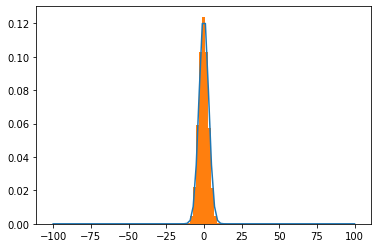

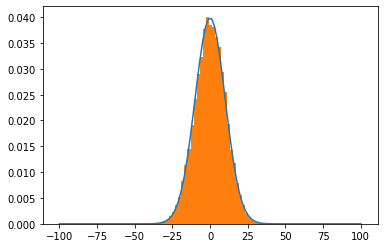

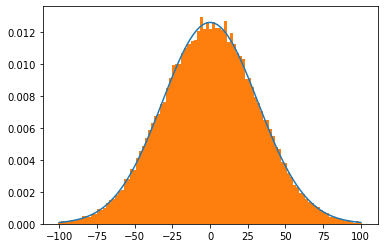

In [5]:
y = RandomWalk(np.zeros(50000), 1001)
x = np.linspace(-100,100,100)
for t in [10,100,1000]:
    P = np.exp(-x**2/(2*t))/np.sqrt(np.pi*2*t) 
    plt.plot(x, P)
    plt.hist(y[t],101,(-101,101),density=True)
    # ビンの幅を2、ビンの中央が0となるように調整
    plt.show()

# 例題27 ランジュバン方程式

In [6]:
def SDE(rhs, t, x0, R, args=(), method="Euler"):
    ans = [x0]
    for i in range(len(t)-1):
        h = t[i+1]-t[i]
        if method=="Euler":
          x1 = x0 + h*rhs(t, x0, R[i], *args)
        elif method=="RK2":
          p1 = x0 + 0.5*h*rhs(t, x0, R[i], *args)
          x1 = x0 + h*rhs(t+0.5*h, p1, R[i], *args)
        ans.append(x1)
        x0 = x1
    return np.array(ans)

In [7]:
rhs = lambda t, x, R, m, mu: (-x/mu + R)/m
m, mu, kBT, N = 1, 2, 0.1, 100000 # パラメータの設定
t, x0 = np.linspace(0,10,101), np.zeros(N)
R = np.sqrt(2*kBT/mu/(t[1]-t[0]))*np.random.randn(len(t),len(x0))
v = SDE(rhs, t, x0, R, (m, mu), "RK2")

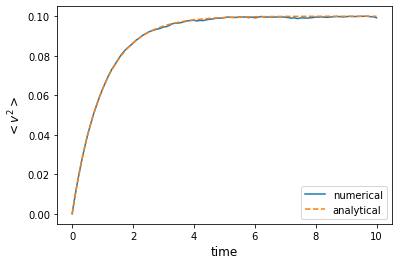

In [9]:
vv = np.average(v*v, axis=1)
I = kBT/m*(1-np.exp(-2*t/(m*mu))) # (10.6)式でv_0=0としている
plt.plot(t, vv, label="numerical")
plt.plot(t, I, ls="dashed", label="analytical")
plt.xlabel("time", fontsize=12)
plt.ylabel("$<v^2>$", fontsize=12)
plt.legend()
plt.show()

# 例題28 幾何ブラウン運動

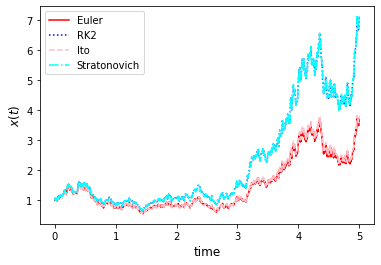

In [10]:
rhs = lambda t, x, R, mu, s: mu*x + s*x*R
t, x0, mu, s = np.linspace(0,5,1000), 1, 0.2, 0.5
h = t[1]-t[0]
R = np.random.randn(len(t))/np.sqrt(h)
W = np.cumsum(h*np.append([0],R))[:-1]
y_Euler = SDE(rhs, t, x0, R, (mu,s), "Euler")
y_RK2   = SDE(rhs, t, x0, R, (mu,s), "RK2")
I_Ito          = np.exp((mu-s**2/2)*t+s*W)
I_Stratonovich = np.exp(mu*t+s*W)
ys = [y_Euler, y_RK2, I_Ito, I_Stratonovich]
cols = ["red", "blue", "pink", "cyan"]
labs = ["Euler", "RK2", "Ito", "Stratonovich"]
stys = ["-", ":", "--", "-."]
for y, col, lab, sty in zip(ys, cols, labs, stys):
    plt.plot(t, y, c=col, ls=sty, label=lab)
plt.xlabel("time", fontsize=12)
plt.ylabel("$x(t)$", fontsize=12)
plt.legend()
plt.show()

# 例題29 確率論的ランダウ-リフシッツ-ギルバート方程式

In [11]:
def rhs(t, x, R, N, alpha, Be):
    # x[:N]がNスピンのphi成分, x[N:]がtheta成分に対応
    # alphaはギルバートダンピング定数, Beは外部磁場を表す
    phi, theta, B = x[:N], x[N:], Be + R
    ct, cp = np.cos(theta), np.cos(phi)
    st, sp = np.sin(theta), np.sin(phi)
    ep = np.array([-sp, cp, np.zeros(N)]).T
    et = np.array([ct*cp, ct*sp, -st]).T
    Ome_p = np.sum(ep*B, axis=1)
    Ome_t = np.sum(et*B, axis=1)
    ans_phi   = -2*(Ome_t - alpha*Ome_p)/st/(1+alpha**2)
    ans_theta =  2*(Ome_p + alpha*Ome_t)/(1+alpha**2)
    return np.array([ans_phi, ans_theta]).flatten()

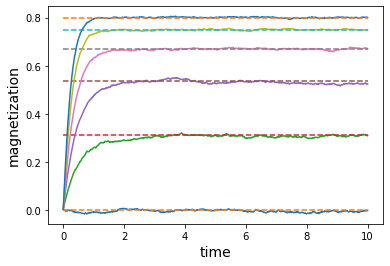

In [12]:
# パラメータと初期状態の設定
N, t, alpha, kBT = 10000, np.linspace(0,10,1000), 0.5, 1
x0, dt = np.pi*np.random.rand(2*N), t[1]-t[0]
for Be in np.linspace(1e-9,5,6): # B_eの値を変えながら計算
    _Be = Be*np.outer(np.ones(N), np.array([1,0,0]))
    R = np.sqrt(alpha*kBT/dt)*np.random.randn(len(t),N,3)
    y = SDE(rhs, t, x0, R, args=(N, alpha, _Be), method='RK2')
    nx = np.sin(y[:,N:])*np.cos(y[:,:N])  # n_xを計算
    I = 1/np.tanh(Be/kBT) - kBT/Be        # 解析的な値
    plt.plot(t, np.average(nx, axis=1))
    plt.plot(t, I*np.ones(len(t)), ls="dashed")
plt.xlabel("time", fontsize=14)
plt.ylabel("magnetization", fontsize=14)
plt.show()